In [1]:
import sys
sys.path.append('../SRC')
import CoDaS_PIOT_general_prior as CoDaS_PIOT
import plot as CoDaS_plot
import Sinkhorn as CoDaS_Sinkhorn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import pickle
import itertools
import matplotlib

In [2]:
def MCMC_sim(T_1, alpha, std, power_k, shift, \
             num_burn_in = 10000, num_sampling = 1000000, num_lag = 200):

    # Hyperparameters
    alphas = [alpha]
    mean = 0.0
    std = std

    # Regularization for calculating W2
    reg = 0.01

    print(T_1)
    K_1, data_K_1, data_K_burn_in, acceptRatio_1 = \
    CoDaS_PIOT.runs(T_1, alphas, mean, std, power_k, shift, num_burn_in, num_sampling, num_lag)

    print('Done...')
    return data_K_1, data_K_burn_in

def autocorr(x,lags,var):
    n_vectors = len(x)
    nr, nc = len(x[0]), len(x[0][0])
    mean = x.mean(axis = 0)
    xp = torch.stack([row-mean for row in x])
    corr = np.array([np.correlate(xp[:,r,c],xp[:,r,c],'full') \
                     for r, c in itertools.product(range(nr), range(nc))])[:, n_vectors-1:]
    div = np.array([n_vectors-i for i in range(len(lags))])
    acorr = corr.sum(axis=0)[:len(lags)]/var/div

    return acorr[:len(lags)]

def plot_row_sum_corr(data):
    nc = len(data[0][0])
    row_sum = []

    for i in range(len(data)):
        row_sum.append(np.array(data[i].sum(axis=1)))

    lags = range(1000)
    var = np.var(row_sum, axis = 0).sum()
    corr = CoDaS_plot.autocorr(row_sum, lags, var)

    x = range(len(lags))
    plus_1_div_exp = 1/np.exp(1)*np.ones(len(lags))
    minus_1_div_exp = - plus_1_div_exp

    plt.plot(lags, corr)
    plt.plot(x, plus_1_div_exp, 'k--')
    plt.plot(x, minus_1_div_exp, 'k--')
    
def plot_corr(data, lag = 1000):
    
    lags = range(lag)
    var = torch.sum(torch.var(data, axis = 0))
    corr = autocorr(data, lags, var)
    
    x = range(len(lags))
    plus_1_div_exp = 1/np.exp(1)*np.ones(len(lags))
    minus_1_div_exp = - plus_1_div_exp

    plt.plot(lags, corr)
    plt.plot(x, plus_1_div_exp, 'k--')
    plt.plot(x, minus_1_div_exp, 'k--')
    plt.xlabel('t')
    plt.ylabel("R(t)")
        
def plot_one_matrix_simplex(M):
    plt.figure(figsize=(6,6))
    plt.subplot(1, 1, 1)
    CoDaS_plot.plot_points(np.array([t[0] for t in M]), 'r', 20)
    CoDaS_plot.plot_points(np.array([t[1] for t in M]), 'g', 20)
    CoDaS_plot.plot_points(np.array([t[2] for t in M]), 'b', 20)
    
def plot_samples(data, bw_method = 0.1):
    nr = len(data[0])
    nc = len(data[0][0])
    x_i = [[] for _ in range(nr)]
    df_all = pd.DataFrame()

    colors = ['r', 'g', 'b']

    for i in range(nr):
        for j in range(nc):
            x_i[i] = np.array([K[i][j].numpy() for K in data])


            df = pd.DataFrame(x_i[i], columns = ['({},{})'.format(i, j)])
            ax1 = df.plot.density(bw_method=bw_method)
            ax1.set_xlim(0, 1)
            ax1.set_ylim(bottom=0)
            
def plot_samples_column(data, bw_method = 0.1):
    nr = len(data[0])
    nc = len(data[0][0])
    x_i = [[] for _ in range(nr)]
    df_all = pd.DataFrame()

    colors = ['r', 'g', 'b']

    for j in range(nc):
        x_i = np.array([[K[i][j].numpy() for i in range(nr)] for K in data])

        df = pd.DataFrame(x_i, columns = ['({},{})'.format(i,j) for i in range(nr) ])

        ax1 = df.plot.density(bw_method=bw_method)
        ax1.set_xlim(0, 1)
        ax1.set_ylim(bottom=0, top=2.5)

    
def plot_samples_column_simplex(data):
    nr = len(data[0])
    nc = len(data[0][0])
    x_i = [[] for _ in range(nr)]
    df_all = pd.DataFrame()

    colors = ['r', 'g', 'b']

    for j in range(nc):
        x_i = np.array([[K[0][j].numpy(), K[1][j].numpy(), K[2][j].numpy()] for K in data])

        df = pd.DataFrame(x_i)

        plt.figure(figsize=(6,6))
        plt.subplot(1, 1, 1)
        CoDaS_plot.plot_points(np.array(x_i), colors[j], 2)

        
def running_average(data):
    
    nc = len(data[0][0])
    x = []

    for i in range(len(data)):
        x.append(np.array(data[i].sum(axis=1)))

    x = np.array(x)
    nr = len(x)
    nc = len(x[0])
    ra = [x[0]]
    for i in range(1, nr):
        ra.append(ra[i-1] + x[i])
    for i in range(1, nr):
        ra[i] /= (i+1)
    return ra

def plot_row_sum_running_average(data):
    ra = running_average(data)
    df_ra = pd.DataFrame(ra)
    ax = df_ra.plot()
    ax.set_ylabel('Row sum')
    ax.set_xlabel('# samples')
    ax.set_ylim(0, 3)





In [3]:
T = [[0.1053, 0.1193, 0.1088],[0.2148, 0.0090, 0.1096],[0.0133, 0.2051, 0.1150]]
T_1 = torch.tensor(T, dtype = torch.float64)
T_1 = T_1/T_1.sum()

In [4]:
T_1

tensor([[0.1053, 0.1193, 0.1088],
        [0.2148, 0.0090, 0.1096],
        [0.0133, 0.2051, 0.1150]], dtype=torch.float64)

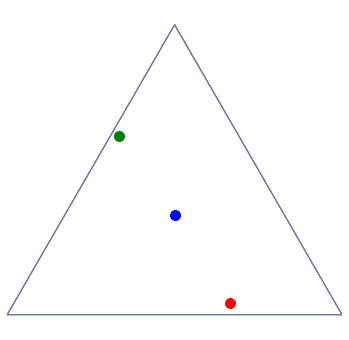

In [5]:
plot_one_matrix_simplex(T_1*3)

T_1 is rescaled so it resides on a simplex. Also need to be rescaled so K_0 = T_1*N_c is on the support.

In [6]:
std = 0.5
power_k = 3
shift = 1.0
alpha = 1.0
num_burn_in = 10000
num_sampling = 1000000
num_lag = 100

data_K_1, data_K_burn_in = MCMC_sim(T_1*3, alpha, std, power_k, shift, num_burn_in, num_sampling, num_lag)

  0%|          | 31/10000 [00:00<00:32, 303.30it/s]

tensor([[0.3158, 0.3578, 0.3263],
        [0.6443, 0.0270, 0.3287],
        [0.0399, 0.6152, 0.3449]], dtype=torch.float64)
Burn in steps:


  0%|          | 41/1000000 [00:00<41:17, 403.57it/s]

Burn in acceptance Ratio: 0.20
Sampling steps:


100%|██████████| 1000000/1000000 [37:53<00:00, 439.83it/s]

Sampling acceptance Ratio: 0.19
Size of data K: 10000
Done...


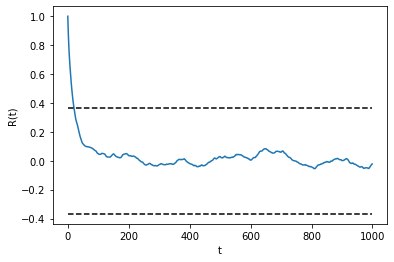

In [7]:
plot_corr(torch.stack(data_K_burn_in))

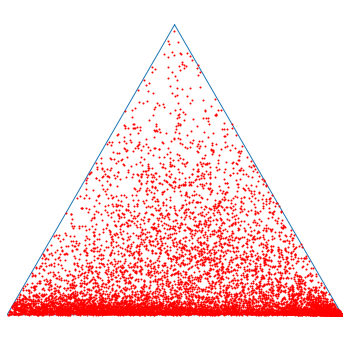

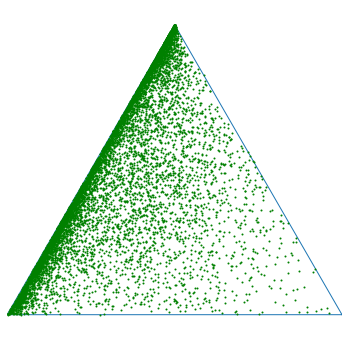

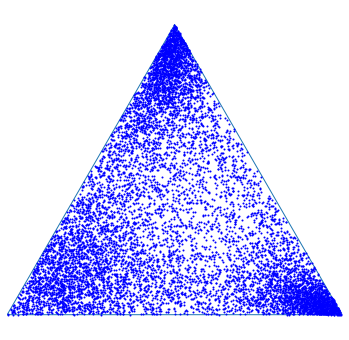

In [8]:
plot_samples_column_simplex(data_K_1)

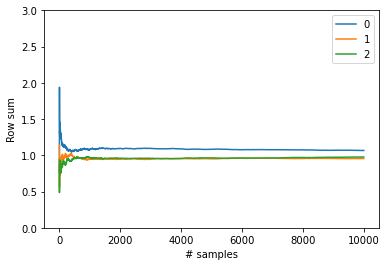

In [9]:
plot_row_sum_running_average(data_K_1)